In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  
plt.rcParams['axes.unicode_minus'] = False 

# 랜덤 시드 설정
seed = 7
np.random.seed(seed)

## 데이터 load

In [3]:
df_main = pd.read_csv('/Users/choeyuhyeon/Desktop/K-DS해커톤/본선/데이터/연도-월_종합_데이터.csv')

# 사용할 피쳐
col = ['부산_주택전세지수', '부산_종합_경제고통지수', #'이혼건수(건)', '혼인건수(건)',
      '부산_종합_실업률 (%)', '부산_여성_경제활동인구 (천명)', '부산_여성_경제활동참가율 (%)',
      '사망자수(명)', '부산_여성_고용률 (%)', '청년층_순이동자수', '부산광역시_물가지수', '고령화지수', '합계출산율']
df_main = df_main[col + ['시점', '출생아수(명)']]

# 시점 컬럼 datetime형으로 변경 및 인덱스 설정
df_main['시점'] = pd.to_datetime(df_main['시점'])
df_main.set_index('시점', drop=False, inplace=True)

# 출생아수가 결측치인 행 삭제
df = df_main.dropna(subset='출생아수(명)').copy()

# 그 외의 결측치 보완
df.fillna(method='bfill', inplace=True)

In [4]:
df_train = df[df['시점'] < '2020']
df_test = df[df['시점'] >= '2020']

In [5]:
pp = Prophet()

# 변수 추가
for c in col : 
    pp.add_regressor(c)
    
pp.fit(df_train[['시점', '출생아수(명)'] + col].rename(columns={'시점':'ds', '출생아수(명)':'y'}))
forecast = pp.predict(df_test[['시점']+col].rename(columns={'시점':'ds'}))
df_test['출생아수(명)_prophet'] = forecast.yhat.values

10:33:32 - cmdstanpy - INFO - Chain [1] start processing
10:33:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/qt/1ygzkpn13md_s45z3pqttsf00000gn/T/ipykernel_22609/1564830387.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['출생아수(명)_prophet'] = forecast.yhat.values


<Axes: xlabel='시점', ylabel='출생아수(명)'>

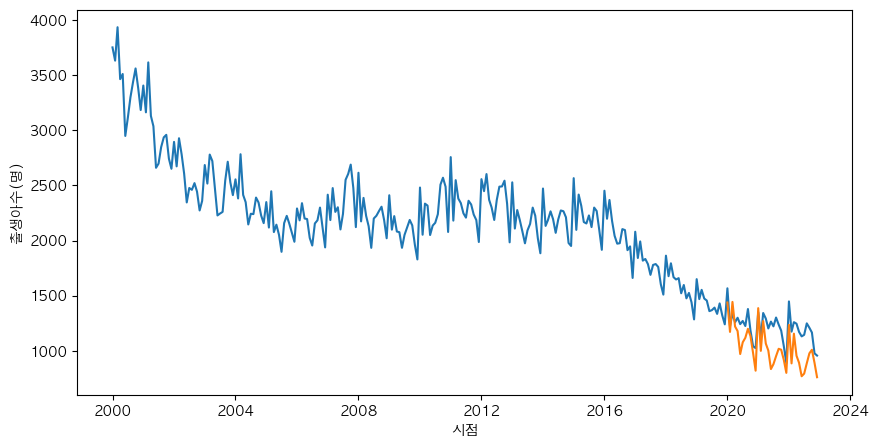

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharex=True)
sns.lineplot(data=df, x=df.index, y='출생아수(명)') # df[['출생아수(명)']].plot(figsize=(14, 7))
sns.lineplot(data=df_test, x=df_test.index, y='출생아수(명)_prophet')# df_test[['출생아수(명)_prophet']].plot(figsize=(14, 7))

In [7]:
print("RMSE of Prophet:", round(np.sqrt(mean_squared_error(df_test['출생아수(명)'], df_test['출생아수(명)_prophet'])), 3))
print("MAE of Prophet:", round(mean_absolute_error(df_test['출생아수(명)'], df_test['출생아수(명)_prophet']),3))
print('MAPE of Prophet:', round(abs((df_test['출생아수(명)'] - df_test['출생아수(명)_prophet'])/df_test['출생아수(명)']*100).mean(),3))

RMSE of Prophet: 217.304
MAE of Prophet: 189.333
MAPE of Prophet: 15.718


## 합계출산율 사용하여 각각의 피쳐 예측
- 합계출산율과 각 독립변수를 사용하여 2040년까지 각 독립변수의 값 예측

In [8]:
df_main = pd.read_csv('/Users/choeyuhyeon/Desktop/K-DS해커톤/본선/데이터/연도-월_종합_데이터.csv')

# 사용할 피쳐
col = ['부산_주택전세지수', '부산_종합_경제고통지수', #'이혼건수(건)', '혼인건수(건)',
      '부산_종합_실업률 (%)', '부산_여성_경제활동인구 (천명)', '부산_여성_경제활동참가율 (%)',
      '사망자수(명)', '부산_여성_고용률 (%)', '청년층_순이동자수', '부산광역시_물가지수', '고령화지수', '합계출산율']
df_main = df_main[col + ['시점', '출생아수(명)']]

# 시점 컬럼 datetime형으로 변경 및 인덱스 설정
df_main['시점'] = pd.to_datetime(df_main['시점'])
df_main.set_index('시점', drop=False, inplace=True)

# 출생아수가 결측치인 행 삭제
df = df_main.dropna(subset='출생아수(명)').copy()

# 그 외의 결측치 보완
df.fillna(method='bfill', inplace=True)

In [9]:
# 예측 시작 시점
s_date = '2023-01-01'

# 예측 종료 시점
e_date = '2040-12-01'

# 예측을 담을 데이터 프레임 생성
ds = pd.date_range(start=s_date, end=e_date, freq='MS')
df_forecast = pd.DataFrame(ds)
df_forecast.rename(columns={0:'ds'}, inplace=True)
df_forecast.set_index('ds', drop=False, inplace=True)

In [10]:
# 합계출산율 데이터 load 및 전처리
p = pd.read_csv('/Users/choeyuhyeon/Desktop/K-DS해커톤/본선/데이터/전국_장래_합계출산율.csv', encoding='utf-8')
p.drop('가정별', axis=1, inplace=True)
p = p.T.rename(columns={0 : '합계출산율'})
p.index = p.index.astype(int)

# 예측값을 담을 데이터프레임 생성
df_forecast = df_forecast.merge(p, left_on=df_forecast.index.year, right_on=p.index)
df_forecast.drop(['key_0'], axis=1, inplace=True)
df_forecast.set_index('ds', drop=False, inplace=True)

In [11]:
# 예측할 피쳐
cols = ['부산_주택전세지수', '부산_종합_경제고통지수', '부산_종합_실업률 (%)', #'이혼건수(건)', '혼인건수(건)', 
       '부산_여성_경제활동인구 (천명)', '부산_여성_경제활동참가율 (%)', '사망자수(명)', '부산_여성_고용률 (%)',
       '청년층_순이동자수', '부산광역시_물가지수', '고령화지수']

In [12]:
# prophet 학습 및 예측 함수
def prophet_predict(df, col, df_forecast) : 

    pp_df = df[['시점', '합계출산율', col]]
    pp = Prophet()
    
    # 합계출산율 변수 추가
    pp.add_regressor('합계출산율')
    
    # 학습
    pp.fit(pp_df[['시점', '합계출산율', col]].rename(columns={'시점':'ds', col:'y'}))
    
    # 예측
    forecast = pp.predict(df_forecast[['ds', '합계출산율']])
    df_forecast[col] = forecast.yhat.values
    return df_forecast

In [13]:
for col in cols : 
    df_forecast = prophet_predict(df, col, df_forecast)

10:34:45 - cmdstanpy - INFO - Chain [1] start processing
10:34:45 - cmdstanpy - INFO - Chain [1] done processing
10:34:46 - cmdstanpy - INFO - Chain [1] start processing
10:34:46 - cmdstanpy - INFO - Chain [1] done processing
10:34:46 - cmdstanpy - INFO - Chain [1] start processing
10:34:46 - cmdstanpy - INFO - Chain [1] done processing
10:34:46 - cmdstanpy - INFO - Chain [1] start processing
10:34:46 - cmdstanpy - INFO - Chain [1] done processing
10:34:46 - cmdstanpy - INFO - Chain [1] start processing
10:34:46 - cmdstanpy - INFO - Chain [1] done processing
10:34:46 - cmdstanpy - INFO - Chain [1] start processing
10:34:46 - cmdstanpy - INFO - Chain [1] done processing
10:34:47 - cmdstanpy - INFO - Chain [1] start processing
10:34:47 - cmdstanpy - INFO - Chain [1] done processing
10:34:47 - cmdstanpy - INFO - Chain [1] start processing
10:34:47 - cmdstanpy - INFO - Chain [1] done processing
10:34:47 - cmdstanpy - INFO - Chain [1] start processing
10:34:47 - cmdstanpy - INFO - Chain [1]

In [14]:
# 2000 ~ 2022년 데이터 셋과 각 독립변수를 예측한 데이터 프레임 합치기
final_df = pd.concat([df, df_forecast], axis=0)
final_df.drop(['ds', '시점'], axis=1, inplace=True)
final_df['시점'] = final_df.index

In [15]:
final_df.tail()

,부산_주택전세지수,부산_종합_경제고통지수,부산_종합_실업률 (%),부산_여성_경제활동인구 (천명),부산_여성_경제활동참가율 (%),사망자수(명),부산_여성_고용률 (%),청년층_순이동자수,부산광역시_물가지수,고령화지수,합계출산율,출생아수(명),시점
2040-08-01,95.757243,8.643938,6.668807,771.938291,52.392844,3426.661723,53.709605,32269.847396,138.764013,447.044747,1.19,NaN,2040-08-01
2040-09-01,95.441564,8.484871,6.470126,778.206438,52.817886,3438.260704,54.070805,32344.365766,139.143989,447.491622,1.19,NaN,2040-09-01
2040-10-01,95.878222,8.417757,6.556711,776.937183,52.741557,3580.033753,54.056961,32502.265491,138.964244,447.934968,1.19,NaN,2040-10-01
2040-11-01,95.076949,8.241646,6.343609,778.132664,52.805197,3565.372351,54.204362,32745.888976,138.617667,448.413205,1.19,NaN,2040-11-01
2040-12-01,94.441441,8.644328,6.758489,775.564178,52.682275,3664.796115,53.760816,32983.186465,138.769628,448.895797,1.19,NaN,2040-12-01


## 2040년까지 출생아수 예측
- 2022년까지 학습 후, 40년까지 예측

In [17]:
train_df = final_df.loc[:'2022']
predict_df = final_df.loc['2023':]

In [18]:
# 사용할 컬럼 정의
cols = list(set(final_df.columns) - set(['출생아수(명)', '시점']))

In [19]:
pp = Prophet()

for col in cols :
    # 독립변수 추가
    pp.add_regressor(col)

pp.fit(train_df[['시점', '출생아수(명)'] + cols].rename(columns={'시점':'ds', '출생아수(명)':'y'}))

forecast = pp.predict(predict_df[['시점'] + cols].rename(columns={'시점':'ds'}))
final_df.loc['2023':, '출생아수(명)'] = forecast.yhat.values

10:35:31 - cmdstanpy - INFO - Chain [1] start processing
10:35:31 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
final_df.tail(5)

,부산_주택전세지수,부산_종합_경제고통지수,부산_종합_실업률 (%),부산_여성_경제활동인구 (천명),부산_여성_경제활동참가율 (%),사망자수(명),부산_여성_고용률 (%),청년층_순이동자수,부산광역시_물가지수,고령화지수,합계출산율,출생아수(명),시점
2040-08-01,95.757243,8.643938,6.668807,771.938291,52.392844,3426.661723,53.709605,32269.847396,138.764013,447.044747,1.19,2070.109810,2040-08-01
2040-09-01,95.441564,8.484871,6.470126,778.206438,52.817886,3438.260704,54.070805,32344.365766,139.143989,447.491622,1.19,2141.411343,2040-09-01
2040-10-01,95.878222,8.417757,6.556711,776.937183,52.741557,3580.033753,54.056961,32502.265491,138.964244,447.934968,1.19,2103.954004,2040-10-01
2040-11-01,95.076949,8.241646,6.343609,778.132664,52.805197,3565.372351,54.204362,32745.888976,138.617667,448.413205,1.19,1969.846482,2040-11-01
2040-12-01,94.441441,8.644328,6.758489,775.564178,52.682275,3664.796115,53.760816,32983.186465,138.769628,448.895797,1.19,1817.568226,2040-12-01


## shift 함수를 사용하여, 연도 인덱스에 연령별(6세 ~ 21세) 인구 데이터 프레임 생성

In [27]:
baby = pd.DataFrame(final_df['출생아수(명)'].groupby(final_df.index.year).sum())
baby

# 연도, 연령 수
baby['6세'] = baby['출생아수(명)'].shift(6)
baby['7세'] = baby['출생아수(명)'].shift(7)
baby['8세'] = baby['출생아수(명)'].shift(8)
baby['9세'] = baby['출생아수(명)'].shift(9)
baby['10세'] = baby['출생아수(명)'].shift(10)
baby['11세'] = baby['출생아수(명)'].shift(11)
baby['12세'] = baby['출생아수(명)'].shift(12)
baby['13세'] = baby['출생아수(명)'].shift(13)
baby['14세'] = baby['출생아수(명)'].shift(14)
baby['15세'] = baby['출생아수(명)'].shift(15)
baby['16세'] = baby['출생아수(명)'].shift(16)
baby['17세'] = baby['출생아수(명)'].shift(17)
baby['18세'] = baby['출생아수(명)'].shift(18)
baby['19세'] = baby['출생아수(명)'].shift(19)
baby['20세'] = baby['출생아수(명)'].shift(20)
baby['21세'] = baby['출생아수(명)'].shift(21)

baby['초등학생'] = baby['6세'] + baby['7세'] + baby['8세'] + baby['9세'] + baby['10세'] + baby['11세']
baby['중학생'] = baby['12세'] +  baby['13세'] +  baby['14세']
baby['고등학생'] = baby['15세'] + baby['16세'] + baby['17세']
baby['대학생'] = baby['18세'] + baby['19세'] + baby['20세'] + baby['21세']
baby['총 학령인구'] = baby['초등학생'] + baby['중학생'] + baby['고등학생'] + baby['대학생']

In [28]:
baby[['초등학생', '중학생', '고등학생', '대학생', '총 학령인구']]

,초등학생,중학생,고등학생,대학생,총 학령인구
2000,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,NaN,NaN,NaN
2002,NaN,NaN,NaN,NaN,NaN
2003,NaN,NaN,NaN,NaN,NaN
2004,NaN,NaN,NaN,NaN,NaN
2005,NaN,NaN,NaN,NaN,NaN
2006,NaN,NaN,NaN,NaN,NaN
2007,NaN,NaN,NaN,NaN,NaN
2008,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN


## 2020년부터 2040년까지의 학령인구 시각화

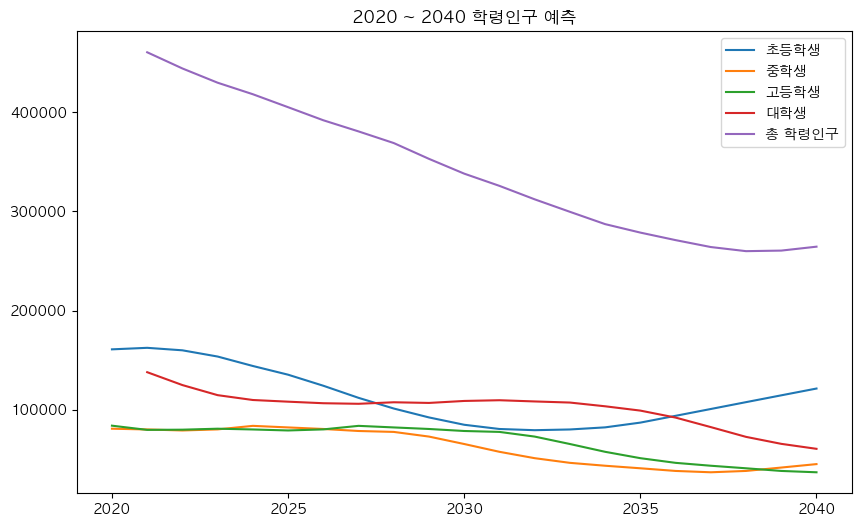

In [36]:
baby.loc['2020':, '초등학생':].plot(figsize=(10, 6))
plt.title('2020 ~ 2040 학령인구 예측')
plt.xticks([2020, 2025, 2030, 2035, 2040])
plt.show()

## 2030, 2040년의 부산광역시 학령인구

In [26]:
print('----------- 연도별 부산광역시 학령인구 -----------')
print('2030년 :', round(baby.loc[2030, '총 학령인구']), '명')
print('2040년 :', round(baby.loc[2040, '총 학령인구']), '명')

----------- 연도별 부산광역시 학령인구 -----------
2030년 : 338106 명
2040년 : 264486 명
